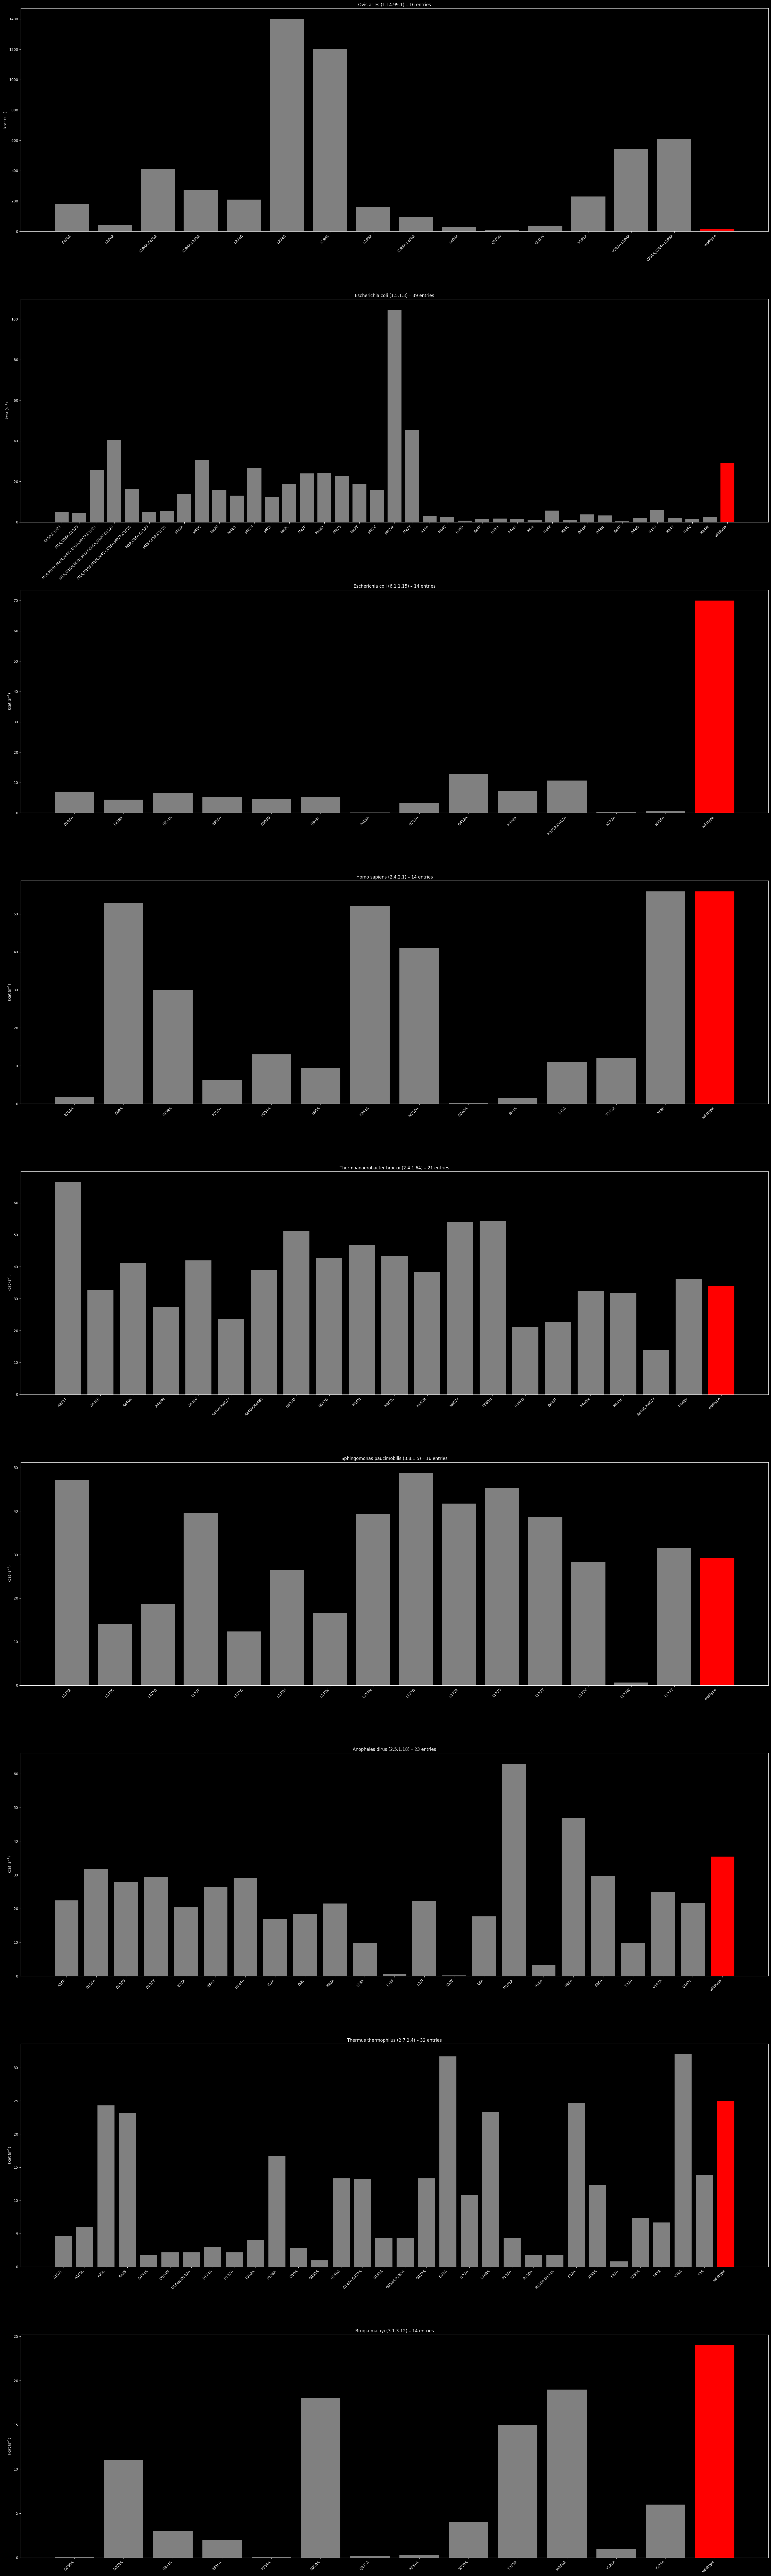

In [8]:
import json
import pandas as pd
import matplotlib.pyplot as plt

# Load and filter JSON
with open("/home/saleh/KinForm-1/data/dlkcat_raw.json") as f:
    data = json.load(f)

data = [
    d for d in data
    if len(d["Sequence"]) <= 1_499
    and float(d["Value"]) > 0
    and "." not in d["Smiles"]
]
df = pd.DataFrame(data)

# Define hardcoded enzyme triplets
hardcoded_triplets = [
    ("1.14.99.1", "Ovis aries", "OO"),
    ("1.5.1.3", "Escherichia coli", "C1C(=NC2=C(N1)N=C(NC2=O)N)CNC3=CC=C(C=C3)C(=O)NC(CCC(=O)[O-])C(=O)[O-]"),
    ("6.1.1.15", "Escherichia coli", "C1CC(NC1)C(=O)O"),
    ("2.4.2.1", "Homo sapiens", "[O-]P(=O)([O-])[O-]"),
    ("2.4.1.64", "Thermoanaerobacter brockii", "C(C1C(C(C(C(O1)O)O)O)O)O"),
    ("3.8.1.5", "Sphingomonas paucimobilis", "C(CBr)Br"),
    ("2.5.1.18", "Anopheles dirus", "C1=CC(=C(C=C1[N+](=O)[O-])[N+](=O)[O-])Cl"),
    ("2.7.2.4", "Thermus thermophilus", "C(C(C(=O)O)N)C(=O)O"),
    ("3.1.3.12", "Brugia malayi", "C(C1C(C(C(C(O1)OC2C(C(C(C(O2)COP(=O)(O)O)O)O)O)O)O)O)O"),
]
# Dark-friendly style
plt.style.use('dark_background')
plt.rcParams.update({
    "axes.edgecolor": "white",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "text.color": "white",
    "figure.facecolor": "black",
    "axes.facecolor": "black",
})

def infer_mutations(wt: str, mut: str) -> str:
    if len(wt) != len(mut):
        raise ValueError("not same length for wildtype and mutant sequences")
    mutations = [f"{wt[i]}{i+1}{mut[i]}" for i in range(len(wt)) if wt[i] != mut[i]]
    return ','.join(mutations) if mutations else "wildtype"

# Set up plot
fig, axes = plt.subplots(nrows=len(hardcoded_triplets), figsize=(30, 100))
if len(hardcoded_triplets) == 1:
    axes = [axes]  # ensure list-like

for i, (ec, org, smi) in enumerate(hardcoded_triplets):
    subset = df[
        (df["ECNumber"] == ec) &
        (df["Organism"] == org) &
        (df["Smiles"] == smi)
    ].copy()

    if subset.empty:
        print(f"⚠️ Skipping {org} ({ec}) — no data found.")
        continue

    subset["Value"] = subset["Value"].astype(float)

    wt_seq = subset[subset["Type"] == "wildtype"]["Sequence"].values
    if len(wt_seq) != 1:
        raise ValueError(f"Expected exactly 1 wildtype for ({ec}, {org}), got {len(wt_seq)}")
    wt_seq = wt_seq[0]

    subset["Mutation"] = subset["Sequence"].apply(lambda s: infer_mutations(wt_seq, s))
    subset = subset.sort_values("Mutation").reset_index(drop=True)

    colors = ['red' if m == "wildtype" else 'gray' for m in subset["Mutation"]]

    ax = axes[i]
    ax.bar(range(len(subset)), subset["Value"], color=colors)
    ax.set_xticks(range(len(subset)))
    ax.set_xticklabels(subset["Mutation"], rotation=45, ha="right")
    ax.set_ylabel("kcat (s$^{-1}$)")
    ax.set_title(f"{org} ({ec}) – {len(subset)} entries")

fig.subplots_adjust(hspace=0.8)
plt.tight_layout()
plt.show()


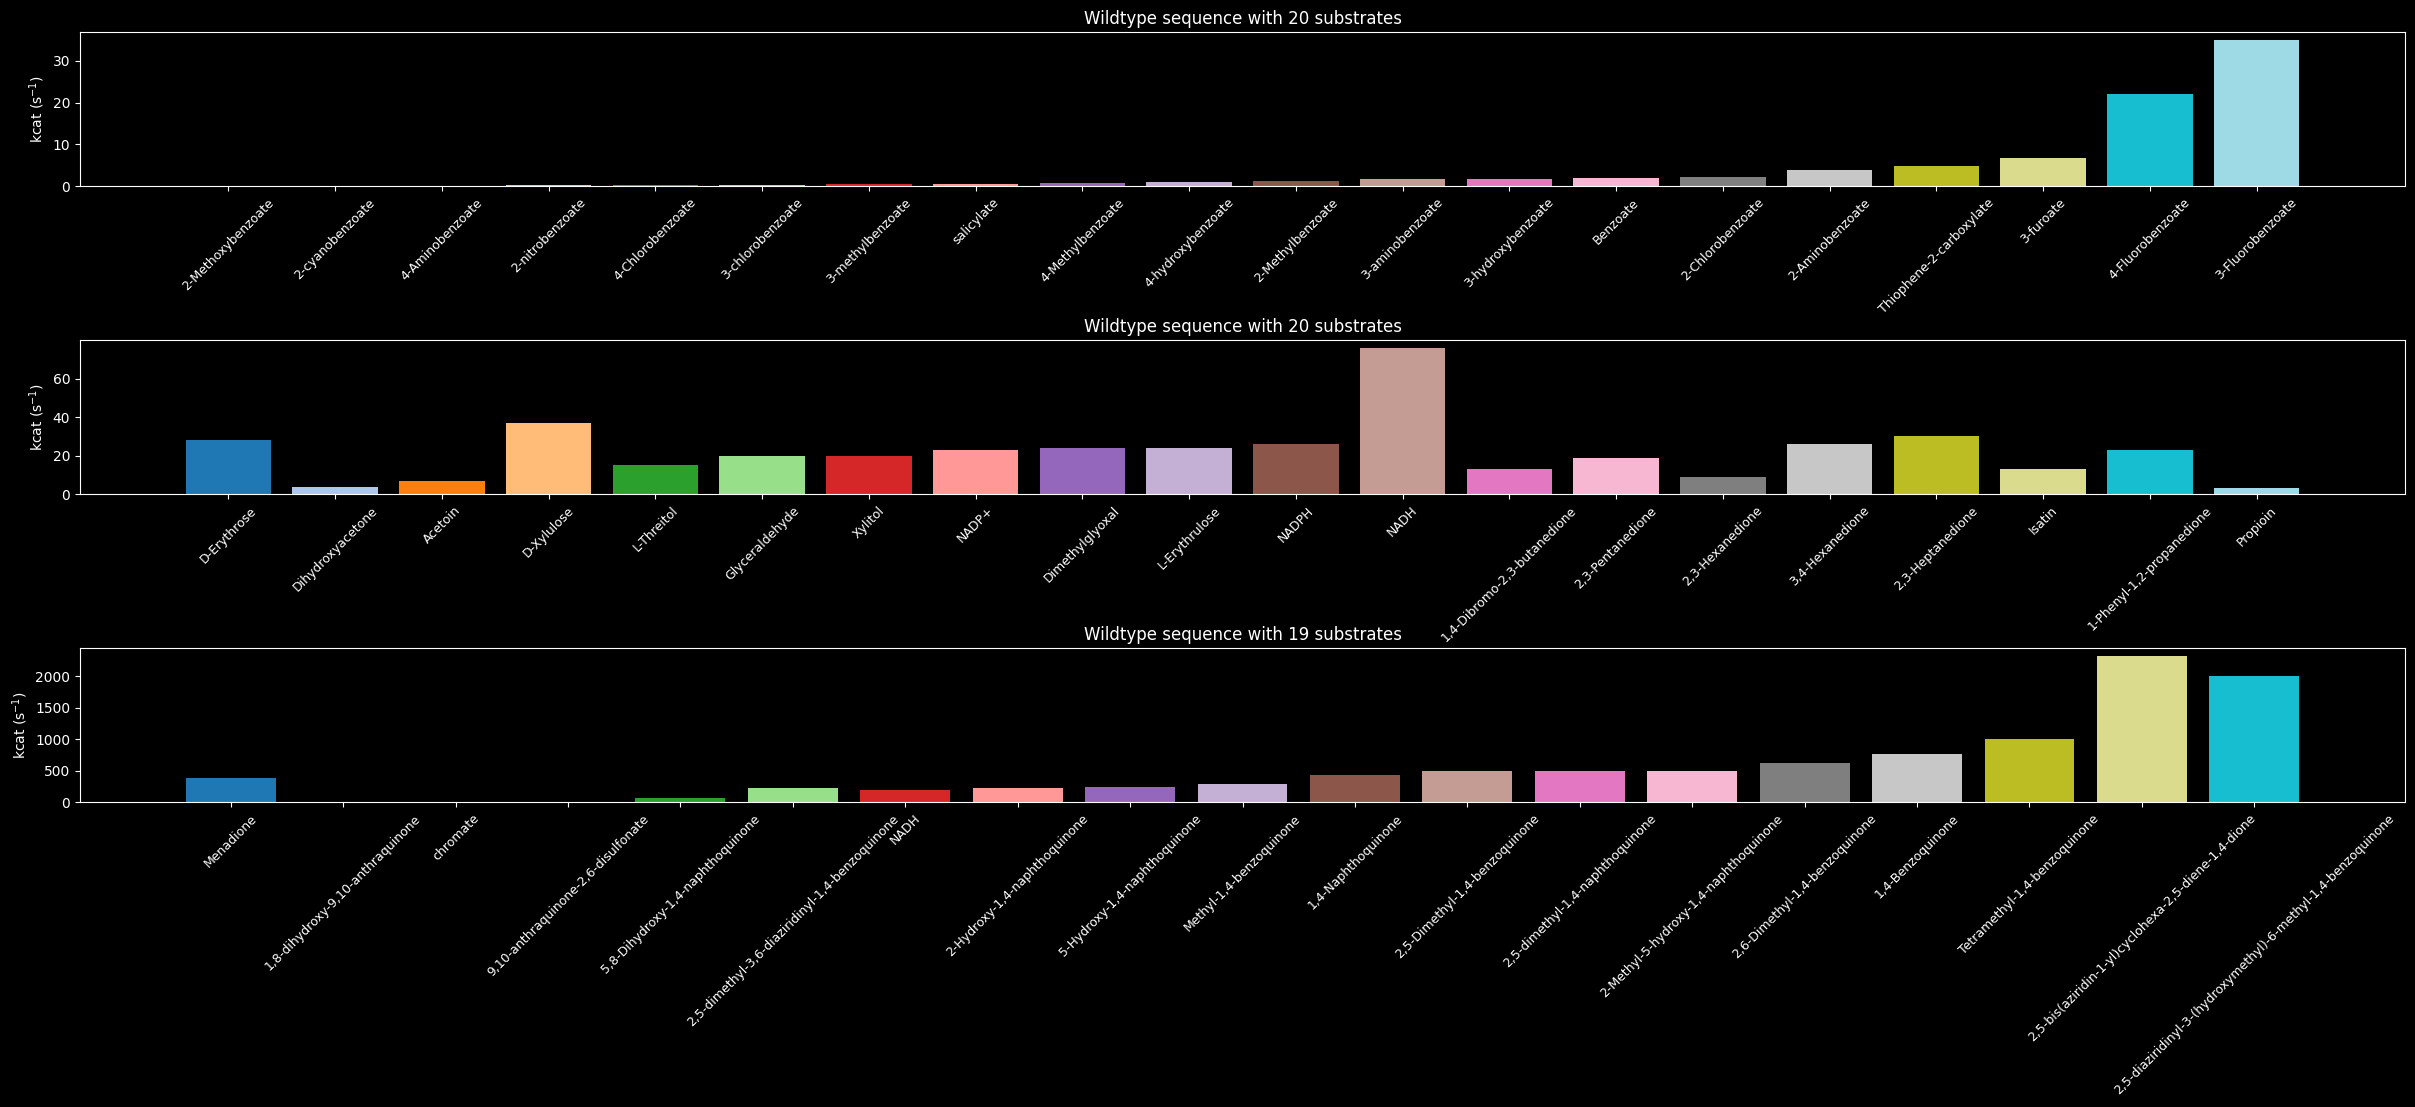

In [50]:

import json
import pandas as pd
import matplotlib.pyplot as plt

# Load JSON
with open("/home/saleh/KinForm-1/data/dlkcat_raw.json") as f:
    data = json.load(f)
    df = pd.DataFrame(data)

# Filter to wildtypes only
wt_df = df[df["Type"] == "wildtype"].copy()

# Count number of unique Substrates per Sequence
substrates_per_seq = wt_df.groupby("Sequence")["Substrate"].nunique()

# Keep only sequences that have >1 unique Substrate
multi_substrate_seqs = substrates_per_seq[substrates_per_seq > 1].sort_values(ascending=False)
# keep only sequences with <= 20 substrates
multi_substrate_seqs = multi_substrate_seqs[multi_substrate_seqs <= 20]
# Select top 3 sequences with most substrate entries
top_3_seqs = multi_substrate_seqs.head(3).index.tolist()

# Dark-friendly style
plt.style.use('dark_background')
plt.rcParams.update({
"axes.edgecolor": "white",
"axes.labelcolor": "white",
"xtick.color": "white",
"ytick.color": "white",
"text.color": "white",
"figure.facecolor": "black",
"axes.facecolor": "black",
})

# Plot each top sequence
fig, axes = plt.subplots(nrows=3, figsize=(30, 10))

for i, seq in enumerate(top_3_seqs):
    subset = wt_df[wt_df["Sequence"] == seq].copy()
    subset["Value"] = subset["Value"].astype(float)

    substrate_labels = subset["Substrate"].astype(str)
    colors = plt.cm.tab20.colors # up to 20 distinct colors
    substrate_to_color = {s: colors[j % len(colors)] for j, s in enumerate(substrate_labels.unique())}
    bar_colors = [substrate_to_color[s] for s in substrate_labels]

    ax = axes[i]
    ax.bar(range(len(subset)), subset["Value"], color=bar_colors)
    ax.set_xticks(range(len(subset)))
    ax.set_xticklabels(substrate_labels, rotation=45, fontsize=9)
    ax.set_ylabel("kcat (s$^{-1}$)")
    ax.set_title(f"Wildtype sequence with {len(subset)} substrates")

fig.subplots_adjust(hspace=1)
plt.show()
